In [1]:
## Example month mean notebook CPOL

In [70]:
from dask_jobqueue import SLURMCluster
import dask.array as da
from dask import delayed
import pyart
import glob
from distributed import Client
%pylab inline
import pandas as pd
import dask.bag as db

Populating the interactive namespace from numpy and matplotlib


In [91]:
def get_rainfall_rate(filename):
    grid = pyart.io.read_grid(filename, include_fields="radar_estimated_rain_rate")
    rr = grid.fields["radar_estimated_rain_rate"]["data"][2]
    del grid
    return rr.filled(np.nan)

def get_mean_rr_rate_in_box(filename, level=3):
    grid = pyart.io.read_grid(filename, include_fields="radar_estimated_rain_rate")
    rr = grid.fields["radar_estimated_rain_rate"]["data"][level].filled(np.nan)
    x = grid.point_x["data"][level]
    y = grid.point_y["data"][level]
    # X range of box 1 -105000.0 47500.0
    # Y range of box 1 -122500.0 32500.0
    our_box = np.logical_and.reduce((x >= -105000., x <= 47500.0, y >= -122500., y <= 32500.))
    return np.nanmean(rr[our_box])

def get_file_time(filename):
    our_parts = filename.split("/")
    return datetime.datetime.strptime(our_parts[-1], "CPOL_%Y%m%d_%H%M_GRIDS_2500m.nc")

In [24]:
list_of_files = glob.glob('/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/2006/200604*/**/*.nc', recursive=True)
list_of_files = sorted(list_of_files)
file_times = np.array([get_file_time(x) for x in list_of_files])

In [97]:
cluster = SLURMCluster(time='1:00:00', processes=36, cores=36, memory='128 GB')
cluster.scale(36)

In [98]:
client = Client(cluster)

In [112]:
client

Client Scheduler: tcp://140.221.70.6:34850 Dashboard: http://140.221.70.6:38361/status,Cluster Workers: 36 Cores: 36 Memory: 128.16 GB


In [58]:
cluster.stop_all_jobs()

In [81]:
cluster.scale(8*36)

In [81]:
grid1 = pyart.io.read_grid(list_of_files[0])
x = grid1.point_x["data"][1]
y = grid1.point_y["data"][1]
rr = grid1.fields["radar_estimated_rain_rate"]["data"][1]
z = grid1.z["data"]
print(z)

[0.0 500.0 1000.0 1500.0 2000.0 2500.0 3000.0 3500.0 4000.0 4500.0 5000.0
 5500.0 6000.0 6500.0 7000.0 7500.0 8000.0 8500.0 9000.0 9500.0 10000.0
 10500.0 11000.0 11500.0 12000.0 12500.0 13000.0 13500.0 14000.0 14500.0
 15000.0 15500.0 16000.0 16500.0 17000.0 17500.0 18000.0 18500.0 19000.0
 19500.0 20000.0]


In [84]:
rr_rate = delayed(get_rainfall_rate)
rrs = [da.from_delayed(rr_rate(x), shape=rr.shape, dtype=float) for x in list_of_files]
rrs = da.stack(rrs)
rrs = da.nanmean(rrs, axis=0)

In [85]:
%time rrate = rrs.compute()

CPU times: user 32.9 s, sys: 2.33 s, total: 35.2 s
Wall time: 51.4 s


Text(0.5,1,'Mean rain rate Apr 2006')

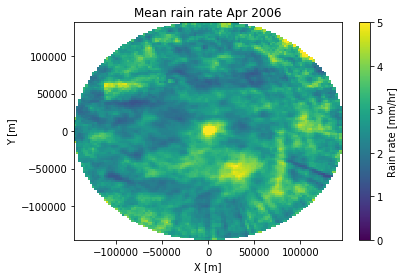

In [86]:
c= plt.pcolormesh(x, y, rrate, vmin=0, vmax=5)
plt.colorbar(c, label='Rain rate [mm/hr]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Mean rain rate Apr 2006')

Text(0,0.5,'Walltime [s]')

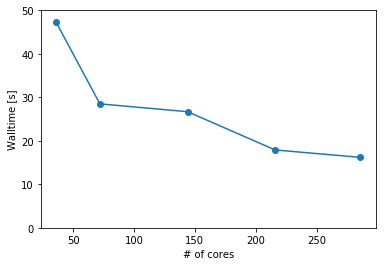

In [98]:
cores = [36, 72, 144, 216, 286]
seconds = [47.3, 28.5, 26.7, 17.9, 16.2]
plt.plot(cores, seconds, marker='o')
plt.ylim([0, 50])
plt.xlabel('# of cores')
plt.ylabel('Walltime [s]')

In [60]:
get_mean_rr_rate_in_box(list_of_files[0])

/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/common.py:98: UserWarning: Unexpected arguments: dict_keys(['include_fields'])
  warnings.warn('Unexpected arguments: %s' % dic.keys())


3.2223852

In [113]:
my_bag = db.from_sequence(list_of_files)

In [114]:
%time timeseries = np.array(my_bag.map(get_mean_rr_rate_in_box).compute())

CPU times: user 9.05 s, sys: 1.25 s, total: 10.3 s
Wall time: 1min 17s


In [115]:
# Create 3 hourly intervals from start time to end time
our_time_bins = np.array(pd.date_range(file_times.min(), file_times.max(), freq='3H').values)
print(our_time_bins.shape)
ftimes_np64 = [np.datetime64(x) for x in file_times]
my_rr_array = np.zeros(len(our_time_bins)-1)
for i in range(len(my_rr_array)):
    ave_inds = np.where(np.logical_and(ftimes_np64 >= our_time_bins[i], ftimes_np64 < our_time_bins[i+1]))
    my_rr_array[i] = np.nanmean(timeseries[ave_inds])

(240,)


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [120]:
sandros_rr_data = np.array([[  3.91665268e+00,   4.64748192e+00,   4.62208271e+00,   2.38778043e+00,
    9.15844202e-01,   6.85004056e-01,   1.49290180e+00,   9.71136749e-01],
 [  7.24617600e-01,   2.14274335e+00,   3.85146976e+00,   5.10213280e+00,
    3.67816424e+00,   2.84212995e+00,   8.01924646e-01,   4.57727015e-01],
 [  1.05067122e+00,   3.37936378e+00,   4.17552757e+00,   1.89552903e+00,
    3.52291894e+00,   2.52983785e+00,   9.77052391e-01,   2.68977427e+00],
 [  4.22394562e+00,   4.24921322e+00,   1.86232519e+00,   1.39031720e+00,
    2.12588596e+00,   1.73011780e+00,   1.07375276e+00,   6.58323586e-01],
 [  4.22742099e-01,   4.32646871e-01,   1.10758734e+00,   1.79825842e-01,
    1.75343525e+00,   5.83197927e+00,   5.67328453e+00,   1.45837617e+00],
 [  7.95290649e-01,   5.18046916e-01,   7.51848340e-01,   6.26050115e-01,
    4.64324147e-01,   1.19037829e-01,   9.26179290e-02,              nan],
 [             nan,              nan,              nan,   3.51445258e-01,
               nan,              nan,              nan,              nan],
 [             nan,              nan,              nan,   2.66205450e-03,
    4.86438900e-01,   6.72578633e-01,              nan,   1.01755238e+00],
 [             nan,              nan,              nan,   3.78109902e-01,
               nan,   4.60275918e-01,              nan,   5.93538815e-03],
 [             nan,   1.85632089e-03,              nan,              nan,
               nan,              nan,   1.60030961e+00,   1.21440542e+00],
 [             nan,              nan,              nan,   1.04895636e-01,
    2.37408816e-03,   2.42777184e-01,              nan,   9.19604599e-01],
 [             nan,   4.50775772e-01,   1.85134554e+00,   1.28262198e+00,
    6.08822203e+00,   4.33943176e+00,   3.54762697e+00,   1.82494628e+00],
 [  1.66797578e+00,   2.74142838e+00,   3.91025329e+00,   4.75270319e+00,
    5.59099388e+00,   1.70741546e+00,   5.69237828e-01,   5.55721391e-03],
 [  9.63882369e-04,   5.21837473e-01,   2.02534199e+00,   2.55276823e+00,
    2.81494522e+00,   8.24616373e-01,   9.26541805e-01,   2.81977113e-02],
 [  5.48624218e-01,   2.28603196e+00,   6.59921217e+00,   3.68412614e+00,
    1.59914696e+00,   1.82187065e-01,   5.53345978e-01,   5.22954583e-01],
 [  8.02516103e-01,              nan,              nan,              nan,
               nan,              nan,              nan,              nan],
 [             nan,   2.30130029e+00,   4.41961670e+00,   2.27292275e+00,
    3.70505154e-01,   3.36023659e-01,   2.63837636e-01,   5.42950397e-03],
 [  3.39581609e+00,   1.05623257e+00,   2.43939304e+00,   5.66655445e+00,
    2.15439463e+00,   4.33196127e-01,   9.98424888e-01,   1.16823471e+00],
 [  4.16639000e-01,   1.79630005e+00,   4.04856634e+00,   2.30573106e+00,
    4.30713326e-01,   9.12217140e-01,   3.70478439e+00,   4.13689280e+00],
 [  1.13838248e-01,   1.24435000e-01,              nan,   1.05333775e-02,
               nan,   9.81846679e-05,              nan,   2.38976837e-03],
 [             nan,              nan,              nan,   2.01916713e-02,
    1.27897561e-01,   2.38907233e-01,   2.92010754e-01,   2.91351408e-01],
 [             nan,              nan,              nan,   9.24569648e-03,
    1.10536911e-01,   2.52385467e-01,   2.75778860e-01,   2.54126061e-02],
 [  1.24922730e-01,   2.31734931e-01,   2.37431392e-01,   3.37567508e-01,
    2.50935286e-01,   3.35491627e-01,   4.32155728e-01,   7.88515806e-01],
 [  8.39973986e-01,   2.13256216e+00,   3.88756347e+00,   5.09488773e+00,
    3.63685608e+00,   2.17486835e+00,   1.59709167e+00,   1.25009394e+00],
 [  1.72675443e+00,   1.43741918e+00,   2.36839271e+00,   2.49820232e+00,
    2.57963181e+00,   4.89172268e+00,   4.76520586e+00,   3.69181919e+00],
 [  4.07333183e+00,   2.98970532e+00,   2.72780275e+00,   2.93972540e+00,
    3.33817184e-01,   5.67214847e-01,   5.43578863e-01,   1.41729510e+00],
 [  2.34883213e+00,   1.79069495e+00,   3.97342014e+00,   1.15014160e+00,
    8.67338085e+00,   3.51223850e+00,   2.59791780e+00,   8.13014805e-01],
 [  9.60304260e-01,   1.92170906e+00,   5.99950457e+00,   1.70590460e+00,
    1.40838817e-01,   8.36503685e-01,              nan,   9.86813474e-03],
 [  1.75739932e+00,   8.48619223e-01,   9.82558131e-01,   9.71817970e-03,
               nan,              nan,              nan,   1.19830377e-03]])

Text(0,0.5,'3h rain rate [mm/hr]')

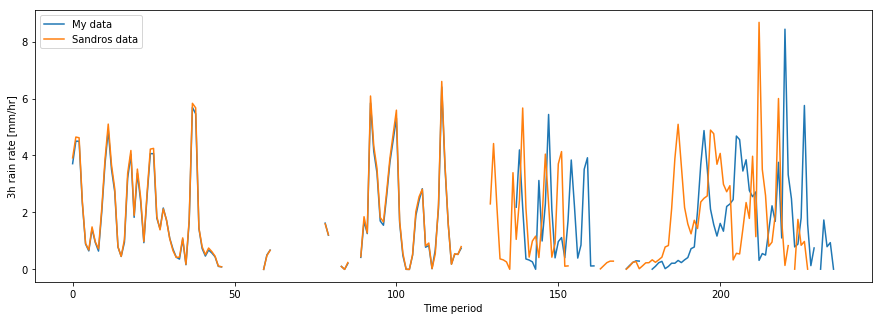

In [124]:
plt.figure(figsize=(15,5))
plt.plot(my_rr_array, label='My data')
plt.plot(sandros_rr_data.flatten(), label='Sandros data')
plt.legend()
plt.xlabel('Time period')
plt.ylabel('3h rain rate [mm/hr]')

In [117]:
print(my_rr_array)

[3.71276188e+00 4.50343752e+00 4.50051451e+00 2.32730484e+00
 8.90567899e-01 6.51203036e-01 1.42330241e+00 9.46957886e-01
 6.44336283e-01 2.01870751e+00 3.70300841e+00 4.89331055e+00
 3.52294230e+00 2.73121476e+00 7.87627220e-01 4.57360804e-01
 9.50701058e-01 3.20251131e+00 4.03768921e+00 1.82832801e+00
 3.37584567e+00 2.40734911e+00 9.39436257e-01 2.58721423e+00
 4.06392479e+00 4.06447792e+00 1.80071449e+00 1.42555666e+00
 2.15641975e+00 1.72839904e+00 1.09370661e+00 7.13633060e-01
 4.31817859e-01 3.62832755e-01 1.06118035e+00 1.65068105e-01
 1.67668080e+00 5.68954992e+00 5.46324062e+00 1.44084847e+00
 7.36376286e-01 4.69632417e-01 6.81298375e-01 5.77314138e-01
 4.42909986e-01 1.07952721e-01 9.02306661e-02            nan
            nan            nan            nan 3.37527752e-01
            nan            nan            nan            nan
            nan            nan            nan 2.50804587e-03
 5.07562041e-01 6.77771688e-01            nan 9.75745738e-01
            nan         